# Semantic Segmentation

In this exercise we will train an end-to-end convolutional neural network for semantic segmentation.
The goal of semantic segmentation is to classify the image on the pixel level, for each pixel
we want to determine the class of the object to which it belongs. This is different from image classification
which classifies an image as a whole and doesn't tell us the location of the objects. This is why semantic segmentation goes into the category of [structured prediction](https://en.wikipedia.org/wiki/Structured_prediction) problems. It answers on both the 'what' and 'where' questions while classifcation tells us only 'what'.

Input image | Target image
-|-
![raw](assets/frankfurt_000000_014480.png) | ![raw](assets/frankfurt_000000_014480_labels.png)
![raw](assets/frankfurt_000001_005898.png) | ![raw](assets/frankfurt_000001_005898_labels.png)


## 1. Cityscapes dataset

[Cityscapes dataset](https://www.cityscapes-dataset.com/dataset-overview/) contains a diverse set of stereo video sequences recorded in street scenes from 50 different cities, with high quality pixel-level annotations. Dataset contains 2975 training and 500 validation images of size 2048x1024. The test set of 1000 images is evaluated on the server and benchmark is available [here](https://www.cityscapes-dataset.com/benchmarks/#scene-labeling-task). Here we will use downsampled images of size 384x160. The original dataset has 19 classes but we lowered that to 7 by uniting similar classes. This makes sense due to low visibility of very small objects in downsampled images. We also have ignore class which we need to ignore during training.

* Download the prepared dataset [here]() and extract it to the current directory. 

ID | Class | Color
-|-|-
0 | road | purple
1 | building | grey
2 | infrastructure | yellow
3 | nature | green
4 | sky | light blue
5 | person | red
6 | vehicle | dark blue
7 | ignore | black

## 2. Building the graph

Let's begin by importing all the modules and setting the fixed random seed.

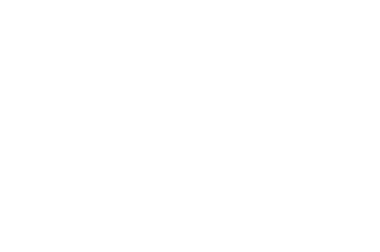

In [1]:
%matplotlib inline

import time
from os.path import join

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

import utils
from data import Dataset

tf.set_random_seed(31415)
tf.logging.set_verbosity(tf.logging.ERROR)

plt.axis('off')
plt.rcParams["figure.figsize"] = (15, 5)

### Dataset

The `Dataset` class implements an iterator which returns the next batch data in each iteration. Data is already normalized to have zero mean and unit variance. The iteration is terminated when we reach the end of the dataset (one epoch).

In [2]:
batch_size = 10
num_classes = Dataset.num_classes
# create the Dataset for training and validation
train_data = Dataset('train', batch_size)
val_data = Dataset('val', batch_size, shuffle=False)

print('Train shape:', train_data.x.shape)
print('Validation shape:', val_data.x.shape)

print('mean = ', train_data.x.mean((0,1,2)))
print('std = ', train_data.x.std((0,1,2)))

Train shape: (2975, 160, 384, 3)
Validation shape: (500, 160, 384, 3)
mean =  [ 73.40336636  83.00610775  72.3497469 ]
std =  [ 47.74221113  48.59657488  47.74085072]


### Inputs

First, we will create input placeholders for Tensorflow computational graph of the model. For a supervised learning model, we need to declare placeholders which will hold input images (x) and target labels (y) of the mini-batches as we feed them to the network.

In [3]:
# store the input image dimensions
height = train_data.height
width = train_data.width
channels = train_data.channels

# create placeholders for inputs
def build_inputs():
    with tf.name_scope('data'):
        x = tf.placeholder(tf.float32, shape=(None, height, width, channels), name='rgb_images')
        y = tf.placeholder(tf.int32, shape=(None, height, width), name='labels')
    return x, y

### Model

Now we can define the computational graph. Here we will heavily use [`tf.layers`](https://www.tensorflow.org/api_docs/python/tf/layers) high level API which handles `tf.Variable` creation for us. The main difference here compared to the classification model is that the network is going to be fully convolutional without any fully connected layers.

In [4]:
# helper function which applies conv2d + ReLU with filter size k
def conv(x, num_maps, k=3):
    x = tf.layers.conv2d(x, num_maps, k, padding='same')
    x = tf.nn.relu(x)
    return x

# helper function for 2x2 max pooling with stride=2
def pool(x):
    return tf.layers.max_pooling2d(x, pool_size=2, strides=2, padding='same')

# this functions takes the input placeholder and the number of classes, builds the model and returns the logits
def build_model(x, num_classes):
    input_size = x.get_shape().as_list()[1:3]
    block_sizes = [64, 64, 64, 64]
    x = conv(x, 32, k=3)
    for i, size in enumerate(block_sizes):
        with tf.name_scope('block'+str(i)):
            x = pool(x)
            x = conv(x, size)
            x = conv(x, size)
    print(x)
    with tf.name_scope('logits'):
        x = tf.layers.conv2d(x, num_classes, 1, padding='same')
        x = tf.image.resize_bilinear(x, input_size, name='upsample_logits')
    return x

### Loss

Now we are going to implement the `build_loss` funcion which will create operations for loss computation and return the final `tf.Tensor` holding the scalar loss value.
Because segmentation is just classification on a pixel level we can again use the cross entropy loss function \\(L\\) between the target one-hot distribution \\( \mathbf{y} \\) and the predicted distribution from a softmax layer \\( \mathbf{s} \\). But compared to image clasificaion here we need to define the loss at each pixel. Below are the equations describing the loss for one example (one pixel in our case).
$$
L = - \sum_{i=1}^{C} y_i log(s_j(\mathbf{x})) \\
s_i(\mathbf{x}) = \frac{e^{x_i}}{\sum_{j=1}^{C} e^{x_j}} \\
$$

In [5]:
# this funcions takes logits and targets (y) and builds the loss subgraph
def build_loss(logits, y):
  with tf.name_scope('loss'):
    # vectorize the image
    y = tf.reshape(y, shape=[-1])
    logits = tf.reshape(logits, [-1, num_classes])
    
    # gather all labels with valid ID
    mask = y < num_classes
    y = tf.boolean_mask(y, mask)
    logits = tf.boolean_mask(logits, mask)

    y_one_hot = tf.one_hot(y, num_classes)
    xent = tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=y_one_hot)

    xent = tf.reduce_mean(xent)
    tf.summary.scalar('cross_entropy', xent)
    return xent

### Putting it all together

Now we can use all the building blocks from above and construct the whole Tensorflow graph in just a couple of lines.

In [6]:
# create inputs
x, y = build_inputs()
# create model
logits = build_model(x, num_classes)
# create loss
loss = build_loss(logits, y)
# we are going to need argmax predictions for IoU
y_pred = tf.argmax(logits, axis=3, output_type=tf.int32)

Tensor("block3/Relu_1:0", shape=(?, 10, 24, 64), dtype=float32)


## 3. Training the model

### Validation

We usually evaluate the semantic segmentation results with [Intersection over Union](https://en.wikipedia.org/wiki/Jaccard_index) measure (IoU aka Jaccard index). Note that accurracy we used on MNIST image classification problem is a bad measure in this case because semantic segmentation datasets are often heavily imbalanced. First we compute IoU for each class in one-vs-all fashion (shown below) and then take the mean IoU (mIoU) over all classes. By taking the mean we are treating all classes as equally important.
$$
IOU = \frac{TP}{TP + FN + FP}
$$

![iou](assets/iou.png)

In [7]:
def validate(sess, data, x, y, y_pred, loss, draw_steps=0):
    print('\nValidation phase:')
    conf_mat = np.zeros((num_classes, num_classes), dtype=np.uint64) 
    for i, (x_np, y_np, names) in enumerate(data):
        start_time = time.time()
        loss_np, y_pred_np = sess.run([loss, y_pred],
          feed_dict={x: x_np, y: y_np})

        duration = time.time() - start_time
        batch_conf_mat = confusion_matrix(y_np.reshape(-1), y_pred_np.reshape(-1))
        batch_conf_mat = batch_conf_mat[:-1,:-1].astype(np.uint64)
        conf_mat += batch_conf_mat

        for j in range(min(draw_steps, batch_size)):
            img_pred = utils.colorize_labels(y_pred_np[j], Dataset.class_info)
            img_true = utils.colorize_labels(y_np[j], Dataset.class_info)
            img_raw = data.get_img(names[j])
            img = np.concatenate((img_raw, img_true, img_pred), axis=1)
            plt.imshow(img)
            plt.show()
            draw_steps -= 1

        if i % 10 == 0:
            string = 'batch %03d loss = %.2f  (%.1f images/sec)' % \
            (i, loss_np, x_np.shape[0] / duration)
            print(string)
    print(conf_mat)
    return utils.print_stats(conf_mat, 'Validation', Dataset.class_info)

### Training

In [8]:
def train(sess, x, y, y_pred, loss, checkpoint_dir):
    num_epochs = 30
    batch_size = 10
    log_dir = 'local/logs'
    utils.clear_dir(log_dir)
    utils.clear_dir(checkpoint_dir)

    learning_rate = 1e-3
    decay_power = 1.0

    global_step = tf.Variable(0, trainable=False)
    decay_steps = num_epochs * train_data.num_batches

    lr = tf.train.polynomial_decay(learning_rate, global_step, decay_steps,
                                   end_learning_rate=0, power=decay_power)

    train_step = tf.train.AdamOptimizer(lr).minimize(loss, global_step=global_step)

    saver = tf.train.Saver()

    summary_all = tf.summary.merge_all()
    train_writer = tf.summary.FileWriter(join(log_dir, 'train'), sess.graph)

    tf.global_variables_initializer().run(session=sess)

    step = 0
    best_iou = 0
    best_epoch = 0
    exp_start_time = time.time()
    for epoch in range(1, num_epochs+1):
        # confusion_mat = np.zeros((num_classes, num_classes), dtype=np.uint64)
        print('\nTraining phase:')
        for x_np, y_np, names in train_data:
            start_time = time.time()
            loss_np, summary, _ = sess.run([loss, summary_all, train_step],
            feed_dict={x: x_np, y: y_np})
            train_writer.add_summary(summary, step)
            duration = time.time() - start_time
            # confusion_mat += batch_conf_mat.astype(np.uint64)
            if step % 20 == 0:
                string = '%s: epoch %d / %d, iter %05d, loss = %.2f  (%.1f images/sec)' % \
                (utils.get_expired_time(exp_start_time), epoch, num_epochs, step, loss_np, batch_size / duration)
                print(string)
            step += 1
        # utils.print_metrics(confusion_mat, 'Train') 
        iou = validate(sess, val_data, x, y, y_pred, loss, draw_steps=0)
        if iou > best_iou:
            best_iou, best_epoch = iou, epoch
            save_path = saver.save(sess, join(checkpoint_dir, 'model.ckpt'))
            print('Model saved in file: ', save_path)
        print('\nBest IoU = %.2f (epoch %d)' % (best_iou, best_epoch))

In [9]:
sess = tf.Session()
train(sess, x, y, y_pred, loss, 'local/checkpoint1')

/usr/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:95: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "



Training phase:


ValueError: Cannot feed value of shape (10, 160, 384, 3) for Tensor 'data/labels:0', which has shape '(?, 160, 384)'

## 4. Restoring the pretrained network

In [ ]:
# restore the best checkpoint
checkpoint_path = 'local/pretrained1/model.ckpt'
saver = tf.train.Saver()
saver.restore(sess, checkpoint_path)
validate(sess, val_data, x, y, y_pred, loss, draw_steps=10)

## Day 4

## 5. Improved model with skip connections

In this part we are going to improve on the pravious model by adding skip connections.

In [ ]:
def upsample(x, skip, num_maps):
    skip_size = skip.get_shape().as_list()[1:3]
    x = tf.image.resize_bilinear(x, skip_size)
    x = tf.concat([x, skip], 3)
    return conv(x, num_maps)

# this functions takes the input placeholder and the number of classes, builds the model and returns the logits
def build_model(x, num_classes):
    input_size = x.get_shape().as_list()[1:3]
    block_sizes = [64, 64, 64, 64]
    skip_layers = []
    
    x = conv(x, 32, k=3)
    for i, size in enumerate(block_sizes):
        with tf.name_scope('block'+str(i)):
            x = pool(x)
            x = conv(x, size)
            x = conv(x, size)
            skip_layers.append(x)
    
    for i, skip in reversed(list(enumerate(skip_layers))):
        with tf.name_scope('block'+str(i)):
            print(i, x, '\n', skip)
            x = upsample(x, skip, block_sizes[i])
    
    with tf.name_scope('logits'):
        x = tf.layers.conv2d(x, num_classes, 1, padding='same')
        x = tf.image.resize_bilinear(x, input_size, name='upsample_logits')
    return x

In [ ]:
sess.close()
tf.reset_default_graph()

# create inputs
x, y = build_inputs()
# create model
logits = build_model(x, num_classes)
# create loss
loss = build_loss(logits, y)
# we are going to need argmax predictions for IoU
y_pred = tf.argmax(logits, axis=3, output_type=tf.int32)

In [ ]:
sess = tf.Session()
train(sess, x, y, y_pred, loss, 'local/checkpoint2')

In [ ]:
# restore the best checkpoint
checkpoint_path = 'local/pretrained2/model.ckpt'
saver = tf.train.Saver()
saver.restore(sess, checkpoint_path)
validate(sess, val_data, x, y, y_pred, loss, draw_steps=10)

## 5. Homework

If you wish you can play with the model. Try to improve on the current IoU.